In [1]:
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
ratings = pd.read_pickle("./Data/small_random_selection_longform.pkl")
ratings2 = pd.read_pickle("./Data/small_random_selection_longform_2.pkl")
user_stats = pd.read_pickle("./Data/moderate_user_stats.pkl")

In [15]:
ratings = pd.concat([ratings, ratings2])

In [16]:
ratings.drop(index=ratings[ratings.duplicated(keep='first')].index, inplace=True)

In [17]:
ratings.shape

(929300, 3)

In [19]:
def center_ratings(ratings_df, users_df):
    
    dfs = []
    for user in ratings_df.user_id.unique():
        temp_df = ratings_df[ratings_df.user_id==user]
        temp_df['centered_ratings'] = temp_df['rating_score'].sub(users_df.at[user, 'mean_score'])
        dfs.append(temp_df)
    
    return dfs

In [22]:
dfs = center_ratings(ratings, user_stats)

In [24]:
centered_ratings = pd.concat(dfs, axis=0)

In [27]:
centered_ratings.reset_index(drop=True, inplace=True)

In [31]:
centered_ratings.head()

,movie_id,rating_score,user_id,centered_ratings,user,movie
0,20183,5,21347583,1.596154,9447,6051
1,3643,1,21347583,-2.403846,9447,3095
2,838,5,21347583,1.596154,9447,766
3,2151,5,21347583,1.596154,9447,1918
4,3430,5,21347583,1.596154,9447,2901


In [32]:
user_enc = LabelEncoder()
centered_ratings['user'] = user_enc.fit_transform(centered_ratings['user_id'].values)
n_users = centered_ratings['user'].nunique()

item_enc = LabelEncoder()
centered_ratings['movie'] = item_enc.fit_transform(centered_ratings['movie_id'].values)
n_movies = centered_ratings['movie'].nunique()

nmovie_id = centered_ratings.movie_id.nunique()
nuser_id = centered_ratings.user_id.nunique()

n_users, n_movies

(44012, 37296)

In [ ]:
# user_enc2 = LabelEncoder()
# ratings2['user'] = user_enc2.fit_transform(ratings2['user_id'].values)
# n_users2 = ratings2['user'].nunique()

# item_enc2 = LabelEncoder()
# ratings2['movie'] = item_enc2.fit_transform(ratings2['movie_id'].values)
# n_movies2 = ratings2['movie'].nunique()

# nmovie_id2 = ratings2.movie_id.nunique()
# nuser_id2 = ratings2.user_id.nunique()

# n_users2, n_movies2

In [51]:
X_train, X_split1 = train_test_split(centered_ratings[['movie', 'user', 'rating_score']], test_size=0.66, random_state=42)

In [52]:
X_train2, X_test = train_test_split(X_split1[['movie', 'user', 'rating_score']], test_size=0.5, random_state=42)

In [53]:
len(X_train), len(X_train2), len(X_test)

(315962, 306669, 306669)

In [ ]:
# l2_1 = keras.regularizers.l2(.1)
# l2_01 = 'l2'
# l2_001 = keras.regularizers.l2(.001)

In [12]:
# HP_NUM_UNITS = [32, 128]
# HP_DROPOUT = [.3, .4]
HP_LEARNING_RATE = [.01, .1]
# HP_REGULARIZER = ['l2']
# HP_EMBEDDING = [15]

In [46]:
X_train

,movie,user,centered_ratings
764730,128,13593,0.978495
815230,471,3020,0.430939
722342,16699,39960,1.206349
865535,228,17341,1.094737
608046,125,11415,0.545455
...,...,...,...
259178,15123,28381,0.290909
365838,108,24041,-1.003401
131932,4660,24633,1.123288
671155,9785,30604,0.234637


In [54]:
del model

In [55]:
def train_test_model(hparams):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    dense1 = keras.layers.Dense(128, 
                           activation='relu', 
                           kernel_regularizer='l2')(conc_layer)
    
#     dropout = x = keras.layers.Dropout(rate=.3, seed=42)(x)
    
    dense2 = keras.layers.Dense(32, 
                           activation='relu', 
                           kernel_regularizer='l2')(dense1)
    
    dropout1 = keras.layers.Dropout(rate=.4, seed=42)(dense2)
    
    dense3 = keras.layers.Dense(32, 
                           activation='relu', 
                           kernel_regularizer='l2')(dropout1)
    
    x_out = keras.layers.Dense(1, 
                               activation='relu',
                              kernel_regularizer='l2')(dense3)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=.01)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())


#     print(hist.history['val_mean_squared_error'])
    return model

In [56]:
model = train_test_model(hparams=[],)

In [57]:
output = model.fit([X_train.movie, X_train.user], 
             X_train.rating_score,  
             batch_size=len(X_train), epochs=100, validation_split=.2)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 16.7754 - root_mean_squared_error: 3.9312 - val_loss: 16.0048 - val_root_mean_squared_error: 3.8529
Epoch 2/100
1/1 [==============================] - 1s 552ms/step - loss: 15.9607 - root_mean_squared_error: 3.8472 - val_loss: 14.9863 - val_root_mean_squared_error: 3.7353
Epoch 3/100
1/1 [==============================] - 1s 600ms/step - loss: 14.9142 - root_mean_squared_error: 3.7256 - val_loss: 13.5011 - val_root_mean_squared_error: 3.5446
Epoch 4/100
1/1 [==============================] - 1s 582ms/step - loss: 13.3831 - root_mean_squared_error: 3.5280 - val_loss: 11.2951 - val_root_mean_squared_error: 3.2297
Epoch 5/100
1/1 [==============================] - 1s 636ms/step - loss: 11.1411 - root_mean_squared_error: 3.2057 - val_loss: 8.1753 - val_root_mean_squared_error: 2.7133
Epoch 6/100
1/1 [==============================] - 1s 556ms/step - loss: 8.0468 - root_mean_squared_error: 2.6896 - val_loss: 4.4869 - val_

Epoch 49/100
1/1 [==============================] - 1s 566ms/step - loss: 1.1914 - root_mean_squared_error: 0.9251 - val_loss: 1.2119 - val_root_mean_squared_error: 0.9371
Epoch 50/100
1/1 [==============================] - 1s 585ms/step - loss: 1.1846 - root_mean_squared_error: 0.9224 - val_loss: 1.2014 - val_root_mean_squared_error: 0.9327
Epoch 51/100
1/1 [==============================] - 1s 574ms/step - loss: 1.1996 - root_mean_squared_error: 0.9317 - val_loss: 1.1984 - val_root_mean_squared_error: 0.9326
Epoch 52/100
1/1 [==============================] - 1s 589ms/step - loss: 1.1966 - root_mean_squared_error: 0.9316 - val_loss: 1.1962 - val_root_mean_squared_error: 0.9333
Epoch 53/100
1/1 [==============================] - 1s 628ms/step - loss: 1.1865 - root_mean_squared_error: 0.9281 - val_loss: 1.2000 - val_root_mean_squared_error: 0.9375
Epoch 54/100
1/1 [==============================] - 1s 586ms/step - loss: 1.1603 - root_mean_squared_error: 0.9160 - val_loss: 1.2174 - val_

Epoch 97/100
1/1 [==============================] - 1s 606ms/step - loss: 0.9002 - root_mean_squared_error: 0.8200 - val_loss: 1.1442 - val_root_mean_squared_error: 0.9580
Epoch 98/100
1/1 [==============================] - 1s 575ms/step - loss: 0.8988 - root_mean_squared_error: 0.8200 - val_loss: 1.1445 - val_root_mean_squared_error: 0.9589
Epoch 99/100
1/1 [==============================] - 1s 604ms/step - loss: 0.8927 - root_mean_squared_error: 0.8171 - val_loss: 1.1397 - val_root_mean_squared_error: 0.9570
Epoch 100/100
1/1 [==============================] - 1s 588ms/step - loss: 0.8895 - root_mean_squared_error: 0.8158 - val_loss: 1.1323 - val_root_mean_squared_error: 0.9537


In [58]:
output2 = model.fit([X_train2.movie, X_train2.user], 
             X_train2.rating_score,  
             batch_size=len(X_train), epochs=100, validation_split=.2)

Epoch 1/100
1/1 [==============================] - 1s 798ms/step - loss: 1.2061 - root_mean_squared_error: 0.9916 - val_loss: 1.1218 - val_root_mean_squared_error: 0.9491
Epoch 2/100
1/1 [==============================] - 1s 634ms/step - loss: 1.1869 - root_mean_squared_error: 0.9828 - val_loss: 1.1330 - val_root_mean_squared_error: 0.9560
Epoch 3/100
1/1 [==============================] - 1s 589ms/step - loss: 1.1586 - root_mean_squared_error: 0.9693 - val_loss: 1.1401 - val_root_mean_squared_error: 0.9609
Epoch 4/100
1/1 [==============================] - 1s 662ms/step - loss: 1.1345 - root_mean_squared_error: 0.9579 - val_loss: 1.1311 - val_root_mean_squared_error: 0.9573
Epoch 5/100
1/1 [==============================] - 1s 540ms/step - loss: 1.1053 - root_mean_squared_error: 0.9437 - val_loss: 1.1055 - val_root_mean_squared_error: 0.9449
Epoch 6/100
1/1 [==============================] - 1s 550ms/step - loss: 1.0803 - root_mean_squared_error: 0.9314 - val_loss: 1.0755 - val_root_m

Epoch 49/100
1/1 [==============================] - 1s 662ms/step - loss: 0.7712 - root_mean_squared_error: 0.7706 - val_loss: 1.0591 - val_root_mean_squared_error: 0.9393
Epoch 50/100
1/1 [==============================] - 1s 557ms/step - loss: 0.7697 - root_mean_squared_error: 0.7700 - val_loss: 1.0600 - val_root_mean_squared_error: 0.9401
Epoch 51/100
1/1 [==============================] - 1s 651ms/step - loss: 0.7671 - root_mean_squared_error: 0.7687 - val_loss: 1.0591 - val_root_mean_squared_error: 0.9400
Epoch 52/100
1/1 [==============================] - 1s 632ms/step - loss: 0.7638 - root_mean_squared_error: 0.7670 - val_loss: 1.0571 - val_root_mean_squared_error: 0.9392
Epoch 53/100
1/1 [==============================] - 1s 654ms/step - loss: 0.7622 - root_mean_squared_error: 0.7663 - val_loss: 1.0559 - val_root_mean_squared_error: 0.9388
Epoch 54/100
1/1 [==============================] - 1s 618ms/step - loss: 0.7607 - root_mean_squared_error: 0.7656 - val_loss: 1.0564 - val_

Epoch 97/100
1/1 [==============================] - 1s 604ms/step - loss: 0.7091 - root_mean_squared_error: 0.7501 - val_loss: 1.0295 - val_root_mean_squared_error: 0.9400
Epoch 98/100
1/1 [==============================] - 0s 498ms/step - loss: 0.7074 - root_mean_squared_error: 0.7494 - val_loss: 1.0288 - val_root_mean_squared_error: 0.9400
Epoch 99/100
1/1 [==============================] - 1s 627ms/step - loss: 0.7077 - root_mean_squared_error: 0.7500 - val_loss: 1.0284 - val_root_mean_squared_error: 0.9401
Epoch 100/100
1/1 [==============================] - 1s 641ms/step - loss: 0.7059 - root_mean_squared_error: 0.7492 - val_loss: 1.0277 - val_root_mean_squared_error: 0.9400


In [67]:
model.save('saved_model/copy13/model.h5')

In [16]:
import matplotlib.pyplot as plt

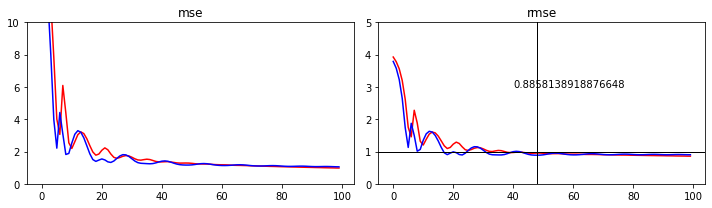

In [55]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))


axs[0].plot(output.history['loss'], color='r')
axs[0].plot(output.history['val_loss'], color='b')

axs[1].plot(output.history['root_mean_squared_error'], color='r')
axs[1].plot(output.history['val_root_mean_squared_error'], color='b')
axs[1].axvline(np.where(output.history['val_root_mean_squared_error']==np.min(output.history['val_root_mean_squared_error'])), 
                 color='k', lw=1)
axs[1].annotate(str(np.min(output.history['val_root_mean_squared_error'])),
                    xy=(40,3),)

#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')

axs[0].set_title("mse")
axs[1].set_title("rmse")

axs[0].set_ylim(0,10)
axs[1].set_ylim(0,5)

axs[1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [56]:
output2 = model.fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=len(X_train), epochs=100, validation_split=.2)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.9742 - root_mean_squared_error: 0.8552 - val_loss: 1.0521 - val_root_mean_squared_error: 0.9004
Epoch 2/100
1/1 [==============================] - 1s 936ms/step - loss: 0.9704 - root_mean_squared_error: 0.8538 - val_loss: 1.0549 - val_root_mean_squared_error: 0.9027
Epoch 3/100
1/1 [==============================] - 1s 881ms/step - loss: 0.9665 - root_mean_squared_error: 0.8523 - val_loss: 1.0571 - val_root_mean_squared_error: 0.9046
Epoch 4/100
1/1 [==============================] - 1s 872ms/step - loss: 0.9625 - root_mean_squared_error: 0.8507 - val_loss: 1.0556 - val_root_mean_squared_error: 0.9045
Epoch 5/100
1/1 [==============================] - 1s 949ms/step - loss: 0.9595 - root_mean_squared_error: 0.8497 - val_loss: 1.0503 - val_root_mean_squared_error: 0.9022
Epoch 6/100
1/1 [==============================] - 1s 832ms/step - loss: 0.9573 - root_mean_squared_error: 0.8491 - val_loss: 1.0445 - val_root_mean

Epoch 49/100
1/1 [==============================] - 1s 915ms/step - loss: 0.8583 - root_mean_squared_error: 0.8114 - val_loss: 0.9927 - val_root_mean_squared_error: 0.8908
Epoch 50/100
1/1 [==============================] - 1s 833ms/step - loss: 0.8581 - root_mean_squared_error: 0.8117 - val_loss: 0.9910 - val_root_mean_squared_error: 0.8902
Epoch 51/100
1/1 [==============================] - 1s 900ms/step - loss: 0.8561 - root_mean_squared_error: 0.8109 - val_loss: 0.9904 - val_root_mean_squared_error: 0.8904
Epoch 52/100
1/1 [==============================] - 1s 846ms/step - loss: 0.8554 - root_mean_squared_error: 0.8110 - val_loss: 0.9902 - val_root_mean_squared_error: 0.8906
Epoch 53/100
1/1 [==============================] - 1s 842ms/step - loss: 0.8528 - root_mean_squared_error: 0.8098 - val_loss: 0.9883 - val_root_mean_squared_error: 0.8900
Epoch 54/100
1/1 [==============================] - 1s 779ms/step - loss: 0.8510 - root_mean_squared_error: 0.8092 - val_loss: 0.9862 - val_

Epoch 97/100
1/1 [==============================] - 1s 883ms/step - loss: 0.8034 - root_mean_squared_error: 0.7972 - val_loss: 0.9489 - val_root_mean_squared_error: 0.8840
Epoch 98/100
1/1 [==============================] - 1s 891ms/step - loss: 0.8018 - root_mean_squared_error: 0.7965 - val_loss: 0.9488 - val_root_mean_squared_error: 0.8843
Epoch 99/100
1/1 [==============================] - 1s 817ms/step - loss: 0.8005 - root_mean_squared_error: 0.7960 - val_loss: 0.9474 - val_root_mean_squared_error: 0.8838
Epoch 100/100
1/1 [==============================] - 1s 868ms/step - loss: 0.8000 - root_mean_squared_error: 0.7960 - val_loss: 0.9464 - val_root_mean_squared_error: 0.8836


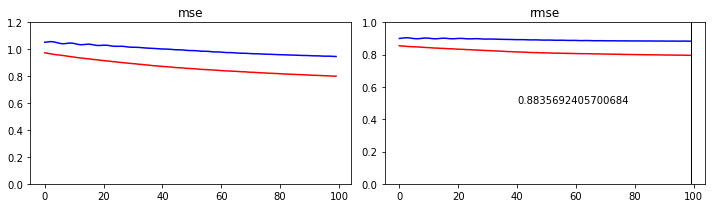

In [57]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))


axs[0].plot(output2.history['loss'], color='r')
axs[0].plot(output2.history['val_loss'], color='b')

axs[1].plot(output2.history['root_mean_squared_error'], color='r')
axs[1].plot(output2.history['val_root_mean_squared_error'], color='b')
axs[1].axvline(np.where(output2.history['val_root_mean_squared_error']==np.min(output2.history['val_root_mean_squared_error'])), 
                 color='k', lw=1)
axs[1].annotate(str(np.min(output2.history['val_root_mean_squared_error'])),
                    xy=(40,.5),)

#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')

axs[0].set_title("mse")
axs[1].set_title("rmse")

axs[0].set_ylim(0,1.2)
axs[1].set_ylim(0,1)

# axs[1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [59]:
dir(model)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compile_was_called',
 '_compiled_tr

In [18]:
print(run_history['run-0'])
print(run_history['run-1'])
# print(run_history['run-2'])
# print(run_history['run-3'])
# print(run_history['run-6'])

{'params': {'HP_LEARNING_RATE': 0.01}, 'output': <tensorflow.python.keras.callbacks.History object at 0x7faecc1bb160>}
{'params': {'HP_LEARNING_RATE': 0.1}, 'output': <tensorflow.python.keras.callbacks.History object at 0x7faec05670d0>}


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

colors = ['red', 'blue', 'green']
for n, key in enumerate(['run-0', 'run-3', 'run-6']):
    
    ax.plot(run_history[key]['output'].history['val_root_mean_squared_error'], color=colors[n], alpha=.8, lw=2)

ax.set_ylim(0,5)
plt.show()

In [62]:
X_train

,movie,user,rating_score
764730,128,13593,5
815230,471,3020,4
722342,16699,39960,5
865535,228,17341,5
608046,125,11415,5
...,...,...,...
259178,15123,28381,4
365838,108,24041,3
131932,4660,24633,5
671155,9785,30604,4


In [63]:
X_train.groupby('user').count().sort_values(by='movie',ascending=False).head()

,movie,rating_score
user,,
19690,41,41
36764,41,41
31060,41,41
25314,40,40
42286,40,40


In [64]:
user = 31060
ratings[ratings.user==user]

AttributeError: 'DataFrame' object has no attribute 'user'

In [65]:
movie_array = ratings[ratings.user==user].movie.values.astype(int)
user = np.array([int(user) for n in range(len(movie_array))])

AttributeError: 'DataFrame' object has no attribute 'user'

In [66]:
pred = model.predict([movie_array, user])

NameError: name 'movie_array' is not defined

In [67]:
list(zip(zip(pred.flatten(), ratings[ratings.user_id==user_id].rating_score.values),movie_array))

[((3.743175, 4), 241),
 ((3.7410965, 3), 4863),
 ((3.1219234, 2), 1226),
 ((3.0741491, 2), 2015),
 ((2.9692314, 5), 2417),
 ((3.5764575, 5), 6114),
 ((3.0853248, 5), 1471),
 ((3.6776721, 3), 2400),
 ((4.030488, 5), 269),
 ((2.581757, 4), 1474),
 ((3.5940585, 2), 7251),
 ((3.9440384, 4), 8358),
 ((3.2713027, 3), 2470),
 ((3.7021978, 5), 219),
 ((4.081106, 5), 2088),
 ((3.7702572, 5), 6297),
 ((2.9568775, 4), 2496),
 ((2.941842, 5), 3484),
 ((2.7150316, 3), 1552),
 ((3.7984316, 3), 2395),
 ((2.801179, 4), 557),
 ((3.8788679, 5), 7399),
 ((4.3565054, 2), 2173),
 ((3.4142294, 2), 2580),
 ((3.4628654, 4), 414),
 ((3.2898645, 5), 1713),
 ((3.249721, 3), 7715),
 ((3.6462386, 5), 1504),
 ((3.3096118, 3), 3184),
 ((4.0056734, 5), 2066),
 ((3.773807, 2), 6051),
 ((3.3861597, 5), 5100),
 ((4.038384, 3), 282),
 ((4.505094, 4), 7576),
 ((2.613674, 4), 2543),
 ((3.7370796, 3), 6686),
 ((3.6898537, 5), 766),
 ((3.973432, 3), 116),
 ((3.4379427, 5), 926),
 ((3.8483272, 5), 779),
 ((3.0198503, 5), 4266

In [68]:
def is_close_enough(pred, ratings):
    val = []
    for pair in zip(pred, ratings):
        if pair[1] == 5:
            val.append(pair[1] - 1 <= pair[0])
        else:
            val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return val

In [69]:
val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user_id==user_id].rating_score.values)

In [70]:
sum(val) / len(pred.flatten())

0.32075471698113206

In [60]:
import seaborn as sns

In [61]:
sns.histplot(pred.flatten(), bins=5)
sns.histplot(ratings[ratings.user_id==user_id].rating_score.values, bins=5)

plt.show()

NameError: name 'pred' is not defined